# Lab 09: Deep Learning Part I: Fully Connected Neural Networks

In class, we have developed the mathematics and programming techniques for binary classification using fully connected neural networks
having one or more hidden layers.

Today, we'll expand on that to consider (small) image classification using again fully connected neural networks with a multinomial
(softmax) output layer.

## MNIST Data

An image is a 2D array of pixels. Pixels can be scalar intensities (for a grayscale / black and white image) or a vector indicating a
point in a color space such as RGB or HSV.

Today we'll consider 8x8 grayscale images of digits from the famous "MNIST" dataset, which was considered a benchmark for machine learning algorithms
up to the early 2000s, before the advent of large-scale image classification datasets.

This dataset in SciKit-Learn has 10 classes, with 180 samples per class in most cases, for a total of 1797 samples.

Let's load the dataset and plot an example.

Text(0.5, 1.0, 'Example MNIST sample (category 0)')

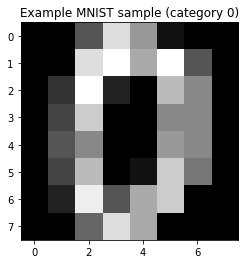

In [18]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load data

data = load_digits()

def convert_to_one_hot(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, int(y[i])] = 1
    return y_vect

# Convert target indices to one-hot representation

y_indices = data.target
y = convert_to_one_hot(y_indices)
X = np.matrix(data.data)
M = X.shape[0]
N = X.shape[1]

# Plot an example

plt.imshow(np.reshape(X[0,:],(8,8)), 'gray')
plt.title('Example MNIST sample (category %d)' % y_indices[0])

## Hand-Coded Fully Connected Neural Network

OK, now let's modify our code from class to work with this dataset and run 100 epochs of training.
The main change is to use a one-hot encoding of the 10 classes at the output layer and to use
the softmax activation function at the output. Some minor changes are required to calculate multinomial
cross entropy loss rather than binary cross entropy loss.

Epoch 0 train loss 2491.017072
Epoch 1 train loss 2488.947736
Epoch 2 train loss 2489.620902
Epoch 3 train loss 2488.821248
Epoch 4 train loss 2488.676089
Epoch 5 train loss 2484.581172
Epoch 6 train loss 2482.508454
Epoch 7 train loss 2478.676346
Epoch 8 train loss 2472.721911
Epoch 9 train loss 2459.357148
Epoch 10 train loss 2433.809901
Epoch 11 train loss 2384.461220
Epoch 12 train loss 2297.018449
Epoch 13 train loss 2185.276556
Epoch 14 train loss 2076.863749
Epoch 15 train loss 1993.034040
Epoch 16 train loss 1926.038307
Epoch 17 train loss 1871.052668
Epoch 18 train loss 1813.680167
Epoch 19 train loss 1751.961525
Epoch 20 train loss 1683.506752
Epoch 21 train loss 1614.188158
Epoch 22 train loss 1549.310936
Epoch 23 train loss 1486.337203
Epoch 24 train loss 1431.742436
Epoch 25 train loss 1376.632926
Epoch 26 train loss 1330.103722
Epoch 27 train loss 1280.761989
Epoch 28 train loss 1234.014039
Epoch 29 train loss 1189.619921
Epoch 30 train loss 1144.626017
Epoch 31 train los

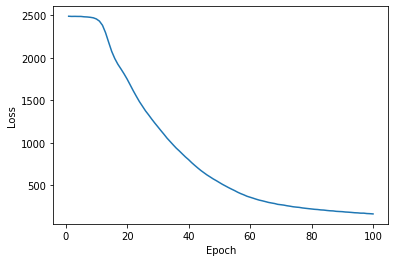

Test accuracy: 0.9110


In [21]:
import random
import warnings
warnings.filterwarnings("ignore")

# Normalize each input feature

def normalize(X):
    M = X.shape[0]
    XX = X - np.tile(np.mean(X,0),[M,1])
    XX = np.divide(XX, np.tile(np.std(XX,0),[M,1]))
    return np.nan_to_num(XX, copy=True,nan=0.0)

XX = normalize(X)

idx = np.arange(0,M)

# Partion data into training and testing dataset

random.shuffle(idx)
percent_train = .6
m_train = int(M * percent_train)
train_idx = idx[0:m_train]
test_idx = idx[m_train:M+1]
X_train = XX[train_idx,:];
X_test = XX[test_idx,:];

y_train = y[train_idx];
y_test = y[test_idx];
y_test_indices = y_indices[test_idx]

# Let's start with a 3-layer network with sigmoid activation functions,
# 6 units in layer 1, and 5 units in layer 2.

h2 = 5
h1 = 6
W = [[], np.random.normal(0,0.1,[N,h1]),
         np.random.normal(0,0.1,[h1,h2]),
         np.random.normal(0,0.1,[h2,10])]
b = [[], np.random.normal(0,0.1,[h1,1]),
         np.random.normal(0,0.1,[h2,1]),
         np.random.normal(0,0.1,[10,1])]
L = len(W)-1

def sigmoid_act(z):
    return 1/(1+np.exp(-z))

def softmax_act(z):
    exps = np.exp(z)
    return exps / np.sum(exps)

def sigmoid_actder(z):
    az = sigmoid_act(z)
    prod = np.multiply(az,1-az)
    return prod

def ff(x,W,b):
    L = len(W)-1
    a = x
    for l in range(1,L+1):
        z = W[l].T*a+b[l]
        if (l == L):
            a = softmax_act(z)
        else:
            a = sigmoid_act(z)
    return a

def loss(y, yhat):
    return - np.dot(y, np.log(yhat))

# Train for 100 epochs with mini-batch size 1

cost_arr = [] 

alpha = 0.01
max_iter = 100
for iter in range(0, max_iter):
    loss_this_iter = 0
    order = np.random.permutation(m_train)
    for i in range(0, m_train):
        
        # Grab the pattern order[i]
        
        x_this = X_train[order[i],:].T
        y_this = y_train[order[i],:]

        # Feed forward step
        
        a = [x_this]
        z = [[]]
        delta = [[]]
        dW = [[]]
        db = [[]]
        for l in range(1,L+1):
            z.append(W[l].T*a[l-1]+b[l])
            if (l == L):
                a.append(softmax_act(z[l]))
            else:
                a.append(sigmoid_act(z[l]))
            # Just to give arrays the right shape for the backprop step
            delta.append([]); dW.append([]); db.append([])
            
        loss_this_pattern = loss(y_this, a[L])
        loss_this_iter = loss_this_iter + loss_this_pattern
            
        # Backprop step. Note that derivative of multinomial cross entropy
        # loss is the same as that of binary cross entropy loss. See
        # https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba
        # for a nice derivation.

        delta[L] = a[L] - np.matrix(y_this).T
        for l in range(L,0,-1):
            db[l] = delta[l].copy()
            dW[l] = a[l-1] * delta[l].T
            if l > 1:
                delta[l-1] = np.multiply(sigmoid_actder(z[l-1]), W[l] *
                             delta[l])
                
        # Check delta calculation
        
        if False:
            print('Target: %f' % y_this)
            print('y_hat: %f' % a[L][0,0])
            print(db)
            y_pred = ff(x_this,W,b)
            diff = 1e-3
            W[1][10,0] = W[1][10,0] + diff
            y_pred_db = ff(x_this,W,b)
            L1 = loss(y_this,y_pred)
            L2 = loss(y_this,y_pred_db)
            db_finite_difference = (L2-L1)/diff
            print('Original out %f, perturbed out %f' %
                 (y_pred[0,0], y_pred_db[0,0]))
            print('Theoretical dW %f, calculated db %f' %
                  (dW[1][10,0], db_finite_difference[0,0]))
        
        for l in range(1,L+1):            
            W[l] = W[l] - alpha * dW[l]
            b[l] = b[l] - alpha * db[l]
            
    cost_arr.append(loss_this_iter[0,0])
    print('Epoch %d train loss %f' % (iter, loss_this_iter))

plt.plot(np.arange(1,max_iter+1,1), cost_arr)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Get test set accuracy

def predict_y(W, b, X):
    M = X.shape[0]
    y_pred = np.zeros(M)
    for i in range(X.shape[0]):
        y_pred[i] = np.argmax(ff(X[i,:].T, W, b))
    return y_pred

y_test_predicted = predict_y(W, b, X_test)
y_correct = y_test_predicted == y_test_indices
test_accuracy = np.sum(y_correct) / len(y_correct)

print('Test accuracy: %.4f' % (test_accuracy))

## In-class exercise

Modify the code above to plot both training loss and test loss as a function of epoch number.
Use early stopping to obtain the best model according to the validation set.
Experiment with the hyperparameters (learning rate, number of layers, number of units per layer) to get
the best result you can.

Describe your experiments and results in your lab report.

## PyTorch tutorial

Is there an easier way to build this type of model? One way is to learn a framework such as TensorFlow or PyTorch. Both of these frameworks have their
pros and cons, but PyTorch is probably the most productive neural network framework for research purposes. We'll use it here.

The material for this tutorial is from
[Anand Saha's PyTorch tutorial](https://github.com/anandsaha/deep.learning.with.pytorch).

### Tensors and Tensor operations

Let's get some hands on experience with tensor creation and operations.
The torch package contains the necessary data structures to create multidimensional tensors.
It also defines the mathematical operations that can be performed on these.

In [1]:
import torch

In [2]:
print(torch.__version__)

1.5.0


### Tensor creation

Create a (2x3) dimentional Tensor.

Note that a) You get back a FloatTensor b) The values are uninitialized

In [3]:
t = torch.Tensor(2, 3)
print(t)

tensor([[0.0000e+00, 0.0000e+00, 1.4013e-45],
        [0.0000e+00, 5.0447e-43, 0.0000e+00]])


The above call was equivalent to

In [4]:
t = torch.FloatTensor(2, 3)
print(t)

tensor([[1.0498e-36, 0.0000e+00, 1.6020e-19],
        [4.4721e+21, 2.7922e+20, 2.4504e-09]])


Inspect type of an element

In [5]:
t[0][0]

tensor(1.0498e-36)

In [6]:
type(t[0][0])

torch.Tensor

Inspect `t`'s dimensions

In [7]:
print(t.size())
print(t.dim())
print(len(t.size()) == t.dim())

torch.Size([2, 3])
2
True


Set values

In [8]:
t[0][0] = 1
t[0][1] = 2
t[0][2] = 3
t[1][0] = 4
t[1][1] = 5
t[1][2] = 6
print(t)

tensor([[1., 2., 3.],
        [4., 5., 6.]])


Let's cast a FloatTensor to IntTensor

In [9]:
t = torch.FloatTensor([1.1, 2.2])
print(t)
t.type(torch.IntTensor)

tensor([1.1000, 2.2000])


tensor([1, 2], dtype=torch.int32)

Let's explore some other ways of creating a tensor

In [10]:
# From another Tensor

t2 = torch.Tensor(t)
print(t2)

tensor([1.1000, 2.2000])


In [11]:
# From a Python list

t3 = torch.IntTensor([[1, 2],[3, 4]])
print(t3)

tensor([[1, 2],
        [3, 4]], dtype=torch.int32)


In [12]:
# From a NumPy array

import numpy as np
a = np.array([55, 66])
t4 = torch.Tensor(a)
print(t4)

tensor([55., 66.])


In [13]:
# Create a Tensor with all zeros

t5 = torch.zeros(2, 3)
print(t5)

tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [14]:
# Create a Tensor with all ones

t6 = torch.ones(2, 3)
print(t6)

tensor([[1., 1., 1.],
        [1., 1., 1.]])


In [15]:
# Create a Tensor with all ones with dimensions 
# of another Tensor

t7 = torch.ones_like(t4)
print(t7)

tensor([1., 1.])


### Tensor operations

Add two Tensors

In [16]:
t1 = torch.ones(2, 2)
t2 = torch.ones(2, 2)
t = t1 + t2
print(t)

tensor([[2., 2.],
        [2., 2.]])


Inplace/out-of-place operations

In [17]:
t1.add(t2)

tensor([[2., 2.],
        [2., 2.]])

In [18]:
print(t1)

tensor([[1., 1.],
        [1., 1.]])


In [19]:
t1.add_(t2)

tensor([[2., 2.],
        [2., 2.]])

In [20]:
print(t1)

tensor([[2., 2.],
        [2., 2.]])


Class methods and package functions

In [21]:
t1.cos()

tensor([[-0.4161, -0.4161],
        [-0.4161, -0.4161]])

In [22]:
torch.cos(t1)

tensor([[-0.4161, -0.4161],
        [-0.4161, -0.4161]])

A few more operations

In [23]:
# Create a one-dimensional tensor of steps equally 
# spaced points between start and end

torch.linspace(3, 10, steps=5)

tensor([ 3.0000,  4.7500,  6.5000,  8.2500, 10.0000])

In [24]:
# Create a 1-D Tensor with values from [start, end)

torch.arange(0, 5)

tensor([0, 1, 2, 3, 4])

In [25]:
# Create a (2x3) Tensor with random values sampled 
# from uniform distrubution on the interval [0,1)

torch.rand((2,3))

tensor([[0.3943, 0.8647, 0.4753],
        [0.9395, 0.2214, 0.1120]])

In [26]:
# Create a (2x3) Tensor with random values sampled 
# from normal distrubution with 0 mean and variance 1

torch.randn((2,3))

tensor([[ 0.1378, -0.2282,  1.7566],
        [ 1.3100, -0.1107,  0.6469]])

In [27]:
# Do a matrix multiply

a = torch.rand((2, 3))
b = torch.rand((3, 2))

torch.mm(a, b)

tensor([[0.4940, 0.5138],
        [0.0164, 0.0536]])

### Variables

Next, let's understand variables in PyTorch and the operations we can perform on them.

In [28]:
import torch
from torch.autograd import Variable

Let's create a small computation graph

In [35]:
x = Variable(torch.FloatTensor([11.2]), requires_grad=True)
y = 2 * x

In [36]:
print(x)
print(y)

tensor([11.2000], requires_grad=True)
tensor([22.4000], grad_fn=<MulBackward0>)


In [37]:
print(x.data)
print(y.data)

tensor([11.2000])
tensor([22.4000])


In [38]:
print(x.grad_fn)
print(y.grad_fn)

None


In [39]:
y.backward() # Calculates the gradients

In [40]:
print(x.grad)
print(y.grad)

tensor([2.])
None


### Working with PyTorch and NumPy

In [41]:
import torch
import numpy as np

Convert a NumPy array to Tensor

In [42]:
n = np.array([2, 3])
t = torch.from_numpy(n)
print(n)
print(t)

[2 3]
tensor([2, 3])


Change a Tensor value, and see the change in 
corresponding NumPy array

In [43]:
n[0] = 100
print(t)

tensor([100,   3])


Convert a Tensor to NumPy array

In [44]:
t = torch.FloatTensor([5, 6])
n = t.numpy()
print(t)
print(n)

tensor([5., 6.])
[5. 6.]


Change a Tensor value, and see the change in corresponding NumPy array

In [45]:
t[0] = 100
print(n)

[100.   6.]


### Tensors on GPU

Check if your machine has GPU support

In [46]:
if torch.cuda.is_available():
    print("GPU Supported")
else:
    print("GPU Not Supported")

GPU Not Supported


Check the number of GPUs attached to this machine

In [47]:
torch.cuda.device_count()

0

Get device name

In [49]:
torch.cuda.get_device_name(0)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

Moving a Tensor to GPU

In [50]:
t = torch.FloatTensor([2, 3])

In [51]:
print(t)

tensor([2., 3.])


In [52]:
t = t.cuda(0)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

Creating a Tensor on GPU, directly

In [53]:
t = torch.cuda.FloatTensor([2, 3])
print(t)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

Bring it back to CPU

In [54]:
t = t.cpu()
print(t)

tensor([2., 3.])


Use device context

In [55]:
with torch.cuda.device(0):
    t = torch.cuda.FloatTensor([2, 3])
    print(t)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx


## MNIST digit recognition using PyTorch

This part of the lab was
taken from the [Kaggle tutorial on MNIST with PyTorch]('https://www.kaggle.com/justuser/mnist-with-pytorch-fully-connected-network).

We will use a fully connected neural network and a batch learning algorithm and explain each
step along the way.

So, with that being said, let's start with imports that we will need.
First of all, we need to import PyTorch. There are some common names for torch modules (like numpy is always named np):  torch.nn.functional is imported as F,  torch.nn is the core module, and is simply imported as nn.
Also, we need numpy. We also use pyplot and seaborn for visualization, but they are not required for the network itself. 
And finally, we use pandas for importing and transforming data.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Now we can import and transform the data. I decided to split it into input and labels right away at this step:

In [4]:
print("Reading the data...")
data = pd.read_csv('train_mnist.csv', sep=",")
test_data = pd.read_csv('test_mnist.csv', sep=",")

print("Reshaping the data...")
dataFinal = data.drop('label', axis=1)
labels = data['label']


dataNp = dataFinal.to_numpy()
labelsNp = labels.to_numpy()
test_dataNp = test_data.to_numpy()

print("Data is ready")

Reading the data...
Reshaping the data...
Data is ready


Now that data is ready, we can take a look at what we're dealing with. I will be using heatmaps from seaborn, which is an excellent tool for matrix visualization. But first, since the images in the MNIST dataset are represented as a long 1d arrays of pixels, we will need to reshape it into 2d array. That's where .reshape() from numpy comes in handy. The pictures are 28 x 28 pixels, so these will be the parameters.

Let's select a couple random samples and visualize them. I will also print their labels, so we can compare images with their actual value:

8  /  9
8  /  4
9  /  1


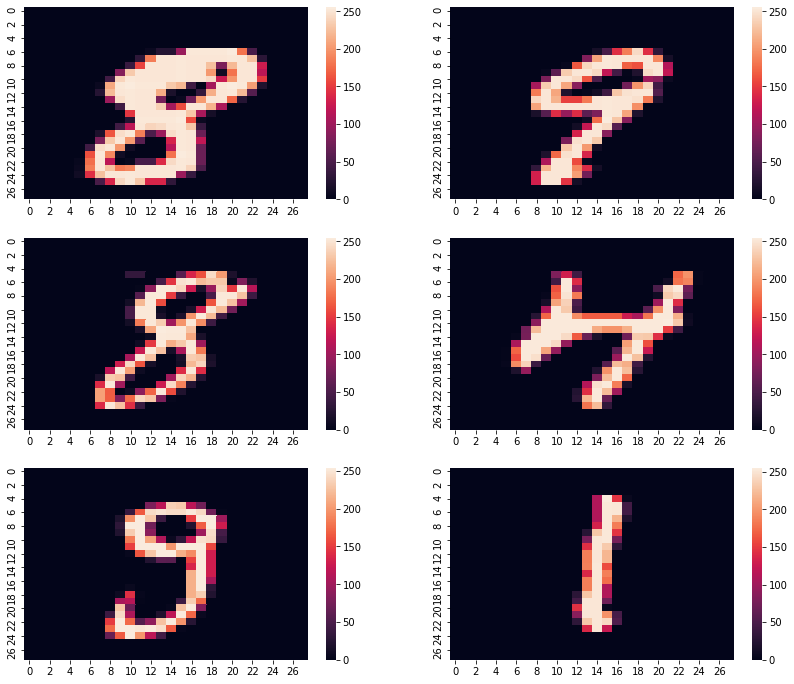

In [5]:
plt.figure(figsize=(14, 12))

pixels = dataNp[10].reshape(28, 28)
plt.subplot(321)
sns.heatmap(data=pixels)

pixels = dataNp[11].reshape(28, 28)
plt.subplot(322)
sns.heatmap(data=pixels)

pixels = dataNp[20].reshape(28, 28)
plt.subplot(323)
sns.heatmap(data=pixels)

pixels = dataNp[32].reshape(28, 28)
plt.subplot(324)
sns.heatmap(data=pixels)

pixels = dataNp[40].reshape(28, 28)
plt.subplot(325)
sns.heatmap(data=pixels)

pixels = dataNp[52].reshape(28, 28)
plt.subplot(326)
sns.heatmap(data=pixels)

print(labels[10], " / ", labels[11])
print(labels[20], " / ", labels[32])
print(labels[40], " / ", labels[52])

PyTorch has it's own way to store data - those are called tensors, and they are just like numpy arrays, but are suited for PyTorch needs. If we want to feed the data to the network, we need to transform the dataset into those tensors. The good news is that PyTorch can easily do that by transforming numpy arrays or regular lists into tensors.

In [6]:
x = torch.FloatTensor(dataNp.tolist())
y = torch.LongTensor(labelsNp.tolist())

Before we start writing the actual network, we need to determine what will be the hyperparameters. Those will not be adjusted during training, so we need to be careful how we set them up. 

Here's what we will specify:
* **input_size** - size of the input layer, it is always fixed (784 pixels)
* **output_size** - size of the output layer, also fixed size (10 for every possible digit)
* **hidden_size** - size of the hidden layer, this parameter determines structure of the network. 200 worked for me, but it is worth to play with this parameter to see what works for you
* **epochs** - how many times will the network go through the entire dataset during training. 
* **learning_rate** - determines how fast will the network learn. You should be very careful about this parameter, because if it is too high, the network won't learn at all, if it is too low, the net will learn too long. I's always about balance. Usualy 10^-3 - 10^-5 works just fine.
* **batch_size** - size of mini batches during training

In [7]:
# hyperparameters
input_size = 784
output_size = 10
hidden_size = 200

epochs = 20
batch_size = 50
learning_rate = 0.00005

Now we can finally write the actual network. To make it all work, the Network class needs to inherit the *nn.Module*, which gives it the basic functionality required, and allows PyTorch to work with it as expected. 

When writing a PyTorch neural network, some things must always be there:
* \__init\__(self) - initializes the net and creates an instance of that *nn.Module*. Here we define the structure of the network.
* forward(self, x) - defines forward propagation and how the data flow through the network. Of course, it is based on the structure that is defined in the previous function.

In the initialization, first of all, we need to initialize super (or base) module that the net inherits. After that first line, is the definition of structure. You can experiment with (put more layers or change hidden layer size, etc.), but this structure worked for me just fine.

In forward propagation we simply reassign the value of x as it flows through the layers and return the [softmax](https://en.wikipedia.org/wiki/Softmax_function) at the end.

In [8]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.log_softmax(x)

After we've defined the network, we can initialize it. 
Also, if we "print" the instance of the net, we can see the structure of it in a neat format:

In [9]:
net = Network()
print(net)

Network(
  (l1): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (l3): Linear(in_features=200, out_features=10, bias=True)
)


Now it's time to set up the [optimizer](http://pytorch.org/docs/master/optim.html) and a loss function. 

*There are quite a lot of things happening behind these two lines of code, so if you don't know what is going on here, don't worry too much for now, it will get clearer eventualy.* 

Optimizer is what  updates the parameters of the network. I will be using Stochastic Gradient Descent with momentum. Also, the optimizer takes the network parameters as an argument, but it's not a big deal since we can get those with .parameters() function.

I decided to use [Cross Entropy Loss](https://en.wikipedia.org/wiki/Cross_entropy) for this problem, but again, there are many options and you are free to choose whatever suits you best.

In [10]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

Now that everything is ready, our network can start learning. I will separate data into minibatches and feed it to the network. It has many advantages over single batch learning, but that is a different story. 

Also, I will use loss_log list to keep track of the loss function during the training process. 

In [12]:
loss_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size] 
        y_mini = y[i:i + batch_size] 
        
        x_var = Variable(x_mini)
        y_var = Variable(y_mini)
        
        optimizer.zero_grad()
        net_out = net(x_var)
        
        loss = loss_func(net_out, y_var)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            loss_log.append(loss.item())
        
    print('Epoch: {} - Loss: {:.6f}'.format(e, loss.item()))

Epoch: 0 - Loss: 0.083200
Epoch: 1 - Loss: 0.010638
Epoch: 2 - Loss: 0.006530
Epoch: 3 - Loss: 0.004620
Epoch: 4 - Loss: 0.005387
Epoch: 5 - Loss: 0.004594
Epoch: 6 - Loss: 0.003482
Epoch: 7 - Loss: 0.003420
Epoch: 8 - Loss: 0.003622
Epoch: 9 - Loss: 0.003535
Epoch: 10 - Loss: 0.003160
Epoch: 11 - Loss: 0.002801
Epoch: 12 - Loss: 0.002589
Epoch: 13 - Loss: 0.001922
Epoch: 14 - Loss: 0.001760
Epoch: 15 - Loss: 0.001515
Epoch: 16 - Loss: 0.001588
Epoch: 17 - Loss: 0.001310
Epoch: 18 - Loss: 0.001409
Epoch: 19 - Loss: 0.001185


So, let's go line by line and see what is happening here:

This is the main loop that goes through all the epochs of training. An epoch is one full training on the full dataset.

    for e in range(epochs):
This is the inner loop that simply goes through the dataset batch by batch:

    for i in range(0, x.shape[0], batch_size):
Here is where we get the batches out of our data and simply assign them to variables for further work:

    x_mini = x[i:i + batch_size] 
    y_mini = y[i:i + batch_size] 
   These two lines are quite *important*. Remember I told you about tensors and how PyTorch stores data in them? That's not the end of story. Actually, to allow the network to work with data, we need a wrapper for those tensors called Variable. It has some additional properties, like allowing automatic gradient computation when backpropagating. It is required for the proper work of PyTorch, so we will add them here and supply tensors as parameters:
   
    x_var = Variable(x_mini)
    y_var = Variable(y_mini)
This line just resets the gradient of the optimizer:
    
    optimizer.zero_grad()
Remember the *forward(self, x)* function that we previously defined? The next line is basically calling this function and does the forward propagation:

    net_out = net(x_var)
This line computes the loss function based on predictions of the net and the correct answers:

    loss = loss_func(net_out, y_var)
Here we compute the gradient based on the loss that we've got. It will be used to adjust parameters of the network.

    loss.backward()
And here is where we finally update our network with new adjusted parameters:

    optimizer.step()
The rest is just logging, which might be helpful to observe how well the network is performing.

After the network is done with training, we can take a look at the loss function, and how it behaved during training:

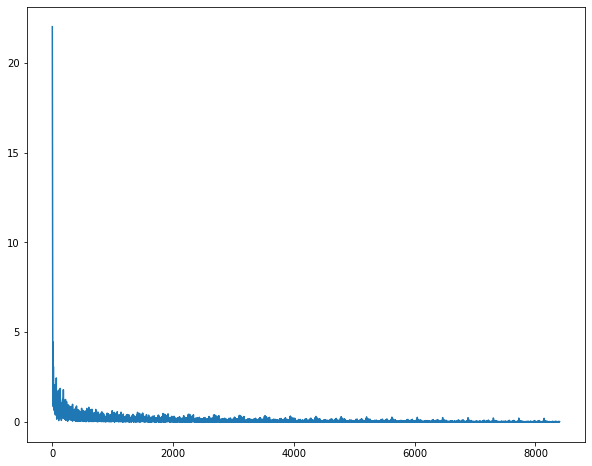

In [13]:
plt.figure(figsize=(10,8))
plt.plot(loss_log)

At this point, the network should be trained, and we can make a prediction using the test dataset. All we need to do is wrap the data into the Variable and feed it to the trained net, so nothing new here.

In [14]:
test = torch.FloatTensor(test_dataNp.tolist())
test_var = Variable(test)

net_out = net(test_var)

print(torch.max(net_out.data, 1)[1].numpy())

[2 0 9 ... 3 9 2]


Now we have out predictions that are ready to be submitted. Before that, we can take a look at predictions and compare them to the actual pictures of digits, just like at the start with training data:

Prediction: 0 / 5
Prediction: 9 / 7
Prediction: 0 / 8


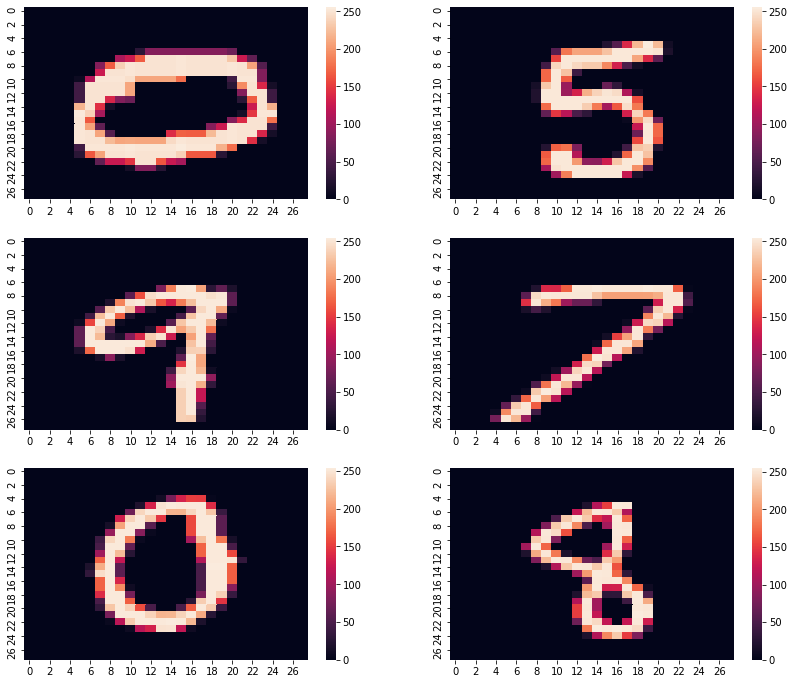

In [15]:
plt.figure(figsize=(14, 12))

pixels = test_dataNp[1].reshape(28, 28)
plt.subplot(321)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[1].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[10].reshape(28, 28)
plt.subplot(322)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[10].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[20].reshape(28, 28)
plt.subplot(323)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[20].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[30].reshape(28, 28)
plt.subplot(324)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[30].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[100].reshape(28, 28)
plt.subplot(325)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[100].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[2000].reshape(28, 28)
plt.subplot(326)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[1].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)


print("Prediction: {} / {}".format(torch.max(net_out.data, 1)[1].numpy()[1], torch.max(net_out.data, 1)[1].numpy()[10]))
print("Prediction: {} / {}".format(torch.max(net_out.data, 1)[1].numpy()[20], torch.max(net_out.data, 1)[1].numpy()[30]))
print("Prediction: {} / {}".format(torch.max(net_out.data, 1)[1].numpy()[100], torch.max(net_out.data, 1)[1].numpy()[2000]))

In [16]:
output = (torch.max(net_out.data, 1)[1]).numpy()
#np.savetxt("out.csv", np.dstack((np.arange(1, output.size+1),output))[0],"%d,%d",header="ImageId,Label")

And that is about it, we've made a simple neural network using PyTorch that can recognize handwritten digits. Not so bad!

When I was writing this notebook, this model scorred 96.6%, which is not perfect by any means, but it's not that bad either. 

I hope this was useful for some of you. If you are totally new to deep learning, I suggest you learn how the neural networks actually work from the inside, especially the backpropagation algorithm.

These videos explain [neural nets](https://www.youtube.com/watch?v=aircAruvnKk&t=708s) and [backpropagation](https://www.youtube.com/watch?v=Ilg3gGewQ5U) quite well.

Also I suggest you to take a look at this [online book](http://neuralnetworksanddeeplearning.com/chap1.html) (it's absolutely free, btw), where neural networks are explained in great detail, and it even has an implementation of the MNIST problem from scratch, using only numpy.

If you have any feedback, feel free to leave comments down below, and good luck with your deep learning adventures :)

## Take-home exercise

Make sure you can run the PyTorch examples of MNIST classification, then apply the PyTorch example to another
classification problem you've worked with this semester, for example the breast cancer dataset. Get familiar with
working with models in PyTorch.

Report your experiments and results in your brief lab report.